In [5]:
! pip install pandas
! pip install numpy
! pip install tensorflow
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 25.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import nltk
import re
import string
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# train_df = pd.read_csv('/kaggle/input/liar-fake-news-dataset/train.tsv', sep='\t', header=None)
# test_df = pd.read_csv('/kaggle/input/liar-fake-news-dataset/test.tsv', sep='\t', header=None)
# valid_df = pd.read_csv('/kaggle/input/liar-fake-news-dataset/valid.tsv', sep='\t', header=None)

In [7]:
from datasets import load_dataset

train_df = load_dataset("liar", split="train").to_pandas()
valid_df = load_dataset("liar", split="validation").to_pandas()
test_df  = load_dataset("liar", split="test").to_pandas()

train_df.rename(columns = {'id': 0, 'label': 1, 'statement': 2, 'subject': 3, 'speaker': 4, 'job_title': 5,
                           'state_info': 6, 'party_affiliation': 7, 'barely_true_counts': 8, 'false_counts': 9,
                           'half_true_counts': 10, 'mostly_true_counts': 11, 'pants_on_fire_counts': 12, 'context': 13
                           }, inplace = True)

test_df.rename(columns = {'id': 0, 'label': 1, 'statement': 2, 'subject': 3, 'speaker': 4, 'job_title': 5,
                           'state_info': 6, 'party_affiliation': 7, 'barely_true_counts': 8, 'false_counts': 9,
                           'half_true_counts': 10, 'mostly_true_counts': 11, 'pants_on_fire_counts': 12, 'context': 13
                           }, inplace = True)

valid_df.rename(columns = {'id': 0, 'label': 1, 'statement': 2, 'subject': 3, 'speaker': 4, 'job_title': 5,
                           'state_info': 6, 'party_affiliation': 7, 'barely_true_counts': 8, 'false_counts': 9,
                           'half_true_counts': 10, 'mostly_true_counts': 11, 'pants_on_fire_counts': 12, 'context': 13
                           }, inplace = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/10269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1283 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1284 [00:00<?, ? examples/s]

In [8]:
def data_preprocessing(dataset):
  #Creating new column called 'label' with 1 for true and mostly-true values, else 0 i.e. 1=real, 0=fake
  dataset['label']=[1 if x==3 or x==2 else 0 for x in dataset[1]]
  #Dropping unwanted columns
  dataset = dataset.drop(labels=[0,1,8,9,10,11,12] ,axis=1)
  #Dealing with empty datapoints for metadata columns - subject, speaker, job, state,affiliation, context
  meta = []
  for i in range(len(dataset)):
      subject = dataset[3][i]
      if subject == 0:
          subject = 'None'

      speaker =  dataset[4][i]
      if speaker == 0:
          speaker = 'None'

      job =  dataset[5][i]
      if job == 0:
          job = 'None'

      state =  dataset[6][i]
      if state == 0:
          state = 'None'

      affiliation =  dataset[7][i]
      if affiliation == 0:
          affiliation = 'None'

      context =  dataset[13][i]
      if context == 0 :
          context = 'None'

      meta.append(str(subject) + ' ' + str(speaker) + ' ' + str(job) + ' ' + str(state) + ' ' + str(affiliation) + ' ' + str(context)) #combining all the meta data columns into a single column

  #Adding cleaned and combined metadata column to the dataset
  dataset[14] = meta
  dataset["sentence"] = dataset[14].astype('str')+" "+dataset[2] #Combining metadata and the text columns into single columns

  dataset = dataset.drop([2,3,4,5,6,7,13,14], axis=1) #dropping metadata columns, as we have merged them into a single column
  dataset.dropna() #Dropping if there are still any null values

  return dataset

In [9]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,0,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [10]:
train_df = data_preprocessing(train_df)
valid_df = data_preprocessing(valid_df)
test_df = data_preprocessing(test_df)

In [11]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [12]:
train_df['sentence']=train_df['sentence'].apply(lambda x:review_cleaning(x))
test_df['sentence']=test_df['sentence'].apply(lambda x:review_cleaning(x))
valid_df['sentence']=valid_df['sentence'].apply(lambda x:review_cleaning(x))

train_df.head()


,label,sentence
0,0,abortion dwaynebohac state representative texa...
1,0,energyhistoryjobaccomplishments scottsurovell ...
2,1,foreignpolicy barackobama president illinois d...
3,0,healthcare blogposting none a news release h...
4,0,economyjobs charliecrist florida democrat an ...


In [13]:
stop = stopwords.words('english')
train_df['sentence'] = train_df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test_df['sentence'] = test_df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
valid_df['sentence'] = valid_df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_df.head()

,label,sentence
0,0,abortion dwaynebohac state representative texa...
1,0,energyhistoryjobaccomplishments scottsurovell ...
2,1,foreignpolicy barackobama president illinois d...
3,0,healthcare blogposting none news release healt...
4,0,economyjobs charliecrist florida democrat inte...


In [14]:
max_words = 5000
maxlen = 100
tokenizer0 = Tokenizer(num_words=max_words)
tokenizer0.fit_on_texts(train_df['sentence'])

tokenizer1 = Tokenizer(num_words=max_words)
tokenizer1.fit_on_texts(test_df['sentence'])

tokenizer2 = Tokenizer(num_words=max_words)
tokenizer2.fit_on_texts(valid_df['sentence'])

train_sequences = tokenizer0.texts_to_sequences(train_df['sentence'])
test_sequences = tokenizer1.texts_to_sequences(test_df['sentence'])
valid_sequences = tokenizer2.texts_to_sequences(valid_df['sentence'])

x_train = pad_sequences(train_sequences, maxlen=maxlen)
x_test = pad_sequences(test_sequences, maxlen=maxlen)
x_valid = pad_sequences(valid_sequences, maxlen=maxlen)

y_train = train_df['label']
y_train = pd.get_dummies(y_train)

y_test = test_df['label']
y_test = pd.get_dummies(y_test)

y_valid = valid_df['label']
y_valid = pd.get_dummies(y_valid)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

(10269, 100) (10269, 2)
(1283, 100) (1283, 2)
(1284, 100) (1284, 2)


### LSTM

In [15]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense

In [26]:

# learning_rates = [0.001, 0.01, 0.1]
# batch_sizes = [32, 64, 128]
# num_epochs = [5]
# dropout_rates = [0.1, 0.2, 0.3]

# best_accuracy = 0
# best_hyperparameters = {}
# i = 0
# for lr in learning_rates:
#     for bs in batch_sizes:
#         for ne in num_epochs:
#             for dr in dropout_rates:
#               model_lstm = Sequential()
#               model_lstm.add(Embedding(max_words, 64, input_length=maxlen))
#               model_lstm.add(LSTM(32,dropout=0.2, recurrent_dropout=0.2))
#               model_lstm.add(Flatten())
#               model_lstm.add(Dense(64, activation='relu'))
#               model_lstm.add(Dense(2, activation='sigmoid'))

#               model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#               model_lstm.summary()

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

embedding_dim = 64

# Define model architecture
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model_lstm.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_lstm.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(2, activation='sigmoid'))

# Compile model
optimizer = Adam(lr=0.001)  # Adjust learning rate as needed
model_lstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Display model summary
model_lstm.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

# Train the model
history = model_lstm.fit(x_train, y_train, epochs=5, batch_size=64,
                         validation_data=(x_valid, y_valid), callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = model_lstm.evaluate(x_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


# model_lstm = Sequential()
# model_lstm.add(Embedding(max_words, 64, input_length=maxlen))
# model_lstm.add(LSTM(32,dropout=0.2, recurrent_dropout=0.2))
# model_lstm.add(Flatten())
# model_lstm.add(Dense(64, activation='relu'))
# model_lstm.add(Dense(2, activation='sigmoid'))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 64)           320000    
                                                                 
 lstm_15 (LSTM)              (None, 100, 64)           33024     
                                                                 
 lstm_16 (LSTM)              (None, 32)                12416     
                                                                 
 dense_16 (Dense)            (None, 64)                2112      
                                                                 
 batch_normalization_7 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 2)                 130       
                                                     

In [ ]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 64)           320000    
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 flatten_4 (Flatten)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
Total params: 334658 (1.28 MB)
Trainable params: 334658 (1.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_lstm.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_valid, y_valid))

Epoch 1/5
161/161 [==============================] - 26s 136ms/step - loss: 0.6410 - accuracy: 0.6448 - val_loss: 0.6423 - val_accuracy: 0.6643
Epoch 2/5
161/161 [==============================] - 22s 135ms/step - loss: 0.5609 - accuracy: 0.7071 - val_loss: 0.6769 - val_accuracy: 0.6301
Epoch 3/5
161/161 [==============================] - 21s 133ms/step - loss: 0.4896 - accuracy: 0.7613 - val_loss: 0.7618 - val_accuracy: 0.5942
Epoch 4/5
161/161 [==============================] - 21s 132ms/step - loss: 0.4244 - accuracy: 0.8016 - val_loss: 0.8998 - val_accuracy: 0.5717
Epoch 5/5
161/161 [==============================] - 22s 135ms/step - loss: 0.3604 - accuracy: 0.8359 - val_loss: 1.0154 - val_accuracy: 0.5646


In [ ]:
y_pred1 = model_lstm.predict(x_test)
y_pred1 = [1 if x[1]>0.5 else 0 for x in y_pred1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred1))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred1))

41/41 [==============================] - 1s 15ms/step
Accuracy: 0.5455962587685113
Classification Report:
              precision    recall  f1-score   support

       False       0.64      0.67      0.65       823
        True       0.35      0.32      0.34       460

    accuracy                           0.55      1283
   macro avg       0.50      0.50      0.50      1283
weighted avg       0.54      0.55      0.54      1283



In [ ]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred1)
cm_cv

array([[553, 270],
       [313, 147]])

<Axes: >

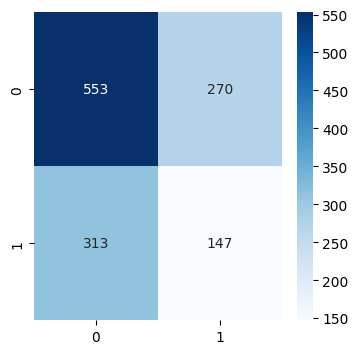

In [ ]:
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

### Bi-LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

# Define model architecture
model_bilstm = Sequential()
model_bilstm.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model_bilstm.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model_bilstm.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)))
model_bilstm.add(Dense(64, activation='relu'))
model_bilstm.add(BatchNormalization())
model_bilstm.add(Dense(2, activation='sigmoid'))  # Binary classification

# Compile model
optimizer = Adam(lr=0.001)  # Adjust learning rate as needed
model_bilstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Display model summary
model_bilstm.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

# Train the model
history = model_bilstm.fit(x_train, y_train, epochs=5, batch_size=32,
                           validation_data=(x_valid, y_valid), callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = model_bilstm.evaluate(x_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 64)           320000    
                                                                 
 bidirectional_6 (Bidirecti  (None, 100, 128)          66048     
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_11 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                     

In [ ]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(max_words, 64, input_length=maxlen))
model_bilstm.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)))
model_bilstm.add(Flatten())
model_bilstm.add(Dense(64, activation='relu'))
model_bilstm.add(Dense(2, activation='sigmoid'))



In [ ]:
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_bilstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 64)           320000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 2)                 130       
                                                                 
Total params: 349122 (1.33 MB)
Trainable params: 349122 (1.33 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
model_bilstm.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_valid, y_valid))

Epoch 1/5
161/161 [==============================] - 46s 243ms/step - loss: 0.6465 - accuracy: 0.6472 - val_loss: 0.6385 - val_accuracy: 0.6721
Epoch 2/5
161/161 [==============================] - 39s 241ms/step - loss: 0.5634 - accuracy: 0.7048 - val_loss: 0.6871 - val_accuracy: 0.6051
Epoch 3/5
161/161 [==============================] - 39s 240ms/step - loss: 0.4872 - accuracy: 0.7674 - val_loss: 0.7607 - val_accuracy: 0.5919
Epoch 4/5
161/161 [==============================] - 38s 238ms/step - loss: 0.4161 - accuracy: 0.8084 - val_loss: 0.8641 - val_accuracy: 0.5421
Epoch 5/5
161/161 [==============================] - 39s 240ms/step - loss: 0.3555 - accuracy: 0.8460 - val_loss: 0.9888 - val_accuracy: 0.5421


In [ ]:
y_pred2 = model_bilstm.predict(x_test)
y_pred2 = [1 if x[1]>0.5 else 0 for x in y_pred2]

41/41 [==============================] - 1s 24ms/step


In [ ]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred2)
cm_cv

array([[516, 307],
       [291, 169]])

<Axes: xlabel='Predicted', ylabel='Actual'>

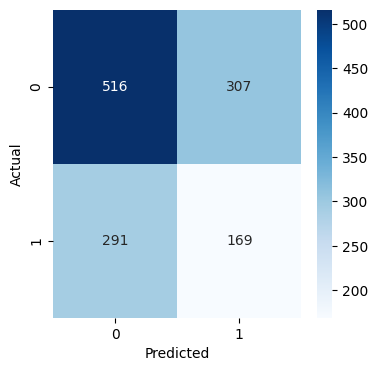

In [ ]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')